# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 1024# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["tau21j2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


20

In [12]:
X_train

array([[ 0.11616433],
       [ 0.7283819 ],
       [ 0.8501291 ],
       ...,
       [-0.15156233],
       [-0.4908988 ],
       [-0.0371694 ]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['tau21j2'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [03:59<6:33:02, 23.82s/it]


Epoch 10:

Generator training loss: -0.10048843396043843
Discriminator training loss: 0.2898189898946735

Generator validation loss: -0.1440291781833426
Discriminator validation loss: 0.3040025196969509


  2%|█▌                                                                            | 20/1000 [07:56<6:26:32, 23.67s/it]


Epoch 20:

Generator training loss: 0.21070097916113223
Discriminator training loss: 0.29762652228113085

Generator validation loss: -0.19086665599072566
Discriminator validation loss: 0.4664882967462305


  3%|██▎                                                                           | 30/1000 [11:54<6:24:52, 23.81s/it]


Epoch 30:

Generator training loss: 0.5296871893392886
Discriminator training loss: 0.0089745665779024

Generator validation loss: -0.1634446398095518
Discriminator validation loss: 0.07587760718936315


  4%|███                                                                           | 40/1000 [15:50<6:18:22, 23.65s/it]


Epoch 40:

Generator training loss: 1.109376272868589
Discriminator training loss: 0.014827455222390606

Generator validation loss: 0.4754646196961403
Discriminator validation loss: -0.017465487027351866


  5%|███▉                                                                          | 50/1000 [19:47<6:13:22, 23.58s/it]


Epoch 50:

Generator training loss: 0.6755176997575604
Discriminator training loss: 0.007251300836739817

Generator validation loss: -0.01555601792153807
Discriminator validation loss: -0.01660202187307076


  6%|████▋                                                                         | 60/1000 [23:43<6:10:41, 23.66s/it]


Epoch 60:

Generator training loss: 0.45988715497033844
Discriminator training loss: 0.010137856000405943

Generator validation loss: -0.3568941421928953
Discriminator validation loss: -0.01563147221567619


  7%|█████▍                                                                        | 70/1000 [27:41<6:08:02, 23.74s/it]


Epoch 70:

Generator training loss: 0.4317746662784144
Discriminator training loss: 0.010138873863248254

Generator validation loss: -0.36648045956599906
Discriminator validation loss: -0.004297786538327422


  8%|██████▏                                                                       | 80/1000 [31:37<6:04:19, 23.76s/it]


Epoch 80:

Generator training loss: 0.4644520487127408
Discriminator training loss: 0.006131219491556398

Generator validation loss: -0.33460359800545897
Discriminator validation loss: 0.008020574271108298


  9%|███████                                                                       | 90/1000 [35:35<6:00:46, 23.79s/it]


Epoch 90:

Generator training loss: 0.5352583689197816
Discriminator training loss: 0.010583895046873126

Generator validation loss: -0.25770944717233296
Discriminator validation loss: -0.015113071809268984


 10%|███████▋                                                                      | 99/1000 [39:07<5:53:50, 23.56s/it]


Epoch 100:

Generator training loss: 0.5163712983167237
Discriminator training loss: 0.005541425500731017

Generator validation loss: -0.4076075323048185
Discriminator validation loss: 0.024581174705879855

Epoch 100:


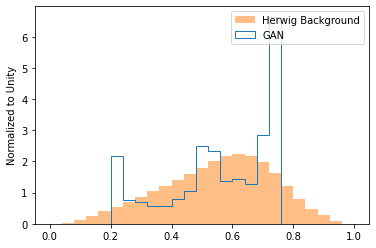

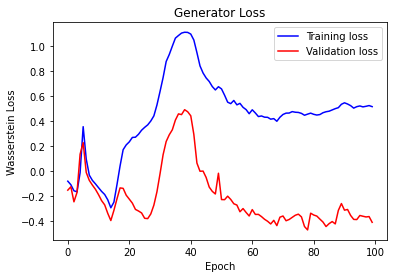

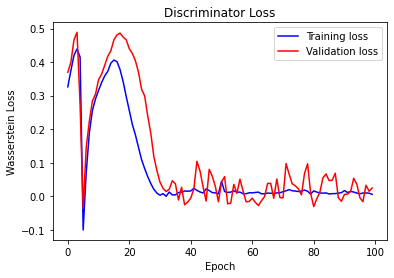

 11%|████████▍                                                                    | 110/1000 [43:30<5:53:14, 23.81s/it]


Epoch 110:

Generator training loss: 0.45782516774584037
Discriminator training loss: 0.007827718010065455

Generator validation loss: -0.4303957488937456
Discriminator validation loss: -0.01638320311794218


 12%|█████████▏                                                                   | 120/1000 [47:27<5:48:39, 23.77s/it]


Epoch 120:

Generator training loss: 0.39438250441043105
Discriminator training loss: 0.004863845606765021

Generator validation loss: -0.5703455590810932
Discriminator validation loss: 0.011010095933670527


 13%|██████████                                                                   | 130/1000 [51:24<5:43:53, 23.72s/it]


Epoch 130:

Generator training loss: 0.329640798942476
Discriminator training loss: 0.005244602542416653

Generator validation loss: -0.6394357620204081
Discriminator validation loss: -0.00981663641475473


 14%|██████████▊                                                                  | 140/1000 [55:19<5:37:05, 23.52s/it]


Epoch 140:

Generator training loss: 0.3268139239583836
Discriminator training loss: 0.005794084413661596

Generator validation loss: -0.6262417665270509
Discriminator validation loss: -0.018017051339275433


 15%|███████████▌                                                                 | 150/1000 [59:16<5:34:49, 23.63s/it]


Epoch 150:

Generator training loss: 0.2765268738396832
Discriminator training loss: 0.003346981774761769

Generator validation loss: -0.7327107132458296
Discriminator validation loss: 0.007617010497969964


 16%|████████████                                                               | 160/1000 [1:03:12<5:30:45, 23.63s/it]


Epoch 160:

Generator training loss: 0.04644047965574246
Discriminator training loss: 0.009515519871043491

Generator validation loss: -0.8926698650981559
Discriminator validation loss: 0.05804007505658312


 17%|████████████▊                                                              | 170/1000 [1:07:08<5:26:19, 23.59s/it]


Epoch 170:

Generator training loss: -0.3362079272504713
Discriminator training loss: 0.01498725691096093

Generator validation loss: -1.07017257076795
Discriminator validation loss: 0.020029978889024427


 18%|█████████████▌                                                             | 180/1000 [1:11:04<5:22:56, 23.63s/it]


Epoch 180:

Generator training loss: -0.4817240294781539
Discriminator training loss: 0.00538666454878018

Generator validation loss: -1.1254514446024035
Discriminator validation loss: -0.006225336988582505


 19%|██████████████▎                                                            | 190/1000 [1:15:00<5:18:12, 23.57s/it]


Epoch 190:

Generator training loss: -0.6499468276653785
Discriminator training loss: 0.008667761870857332

Generator validation loss: -1.3631812500171974
Discriminator validation loss: -0.006747939256993199


 20%|██████████████▉                                                            | 199/1000 [1:18:34<5:14:49, 23.58s/it]


Epoch 200:

Generator training loss: -0.6229226694243853
Discriminator training loss: 0.005529286693709253

Generator validation loss: -1.4811543470523396
Discriminator validation loss: 0.03051114420131704

Epoch 200:


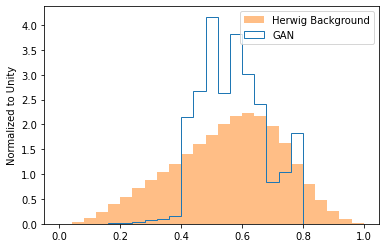

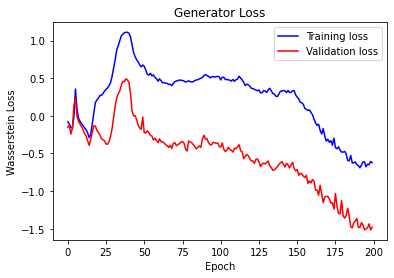

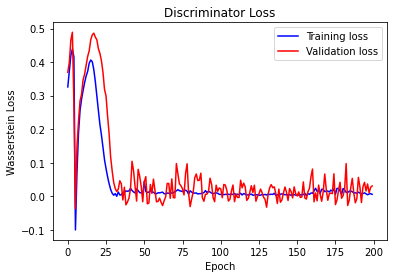

 21%|███████████████▊                                                           | 210/1000 [1:22:55<5:12:13, 23.71s/it]


Epoch 210:

Generator training loss: -0.4711879175461707
Discriminator training loss: 0.007747890265308656

Generator validation loss: -1.3804186929444797
Discriminator validation loss: 0.008051171789821772


 22%|████████████████▌                                                          | 220/1000 [1:26:51<5:08:00, 23.69s/it]


Epoch 220:

Generator training loss: -0.562021687138276
Discriminator training loss: 0.005693650102181041

Generator validation loss: -1.5148136605981921
Discriminator validation loss: 0.011014564897032258


 23%|█████████████████▎                                                         | 230/1000 [1:30:48<5:05:12, 23.78s/it]


Epoch 230:

Generator training loss: -0.6578702757267353
Discriminator training loss: 0.005672645565287208

Generator validation loss: -1.5621023959800846
Discriminator validation loss: 0.0011963716217414017


 24%|██████████████████                                                         | 240/1000 [1:34:44<4:59:05, 23.61s/it]


Epoch 240:

Generator training loss: -0.7517510321133775
Discriminator training loss: 0.006706006662386512

Generator validation loss: -1.7237032046083545
Discriminator validation loss: 0.019061309372773394


 25%|██████████████████▊                                                        | 250/1000 [1:38:40<4:53:40, 23.49s/it]


Epoch 250:

Generator training loss: -0.8414616030259211
Discriminator training loss: 0.006628159059269183

Generator validation loss: -1.8215362297706916
Discriminator validation loss: -0.0016619245538184587


 26%|███████████████████▌                                                       | 260/1000 [1:42:35<4:51:26, 23.63s/it]


Epoch 260:

Generator training loss: -1.0262040833795005
Discriminator training loss: 0.0021392281393201188

Generator validation loss: -1.9841558141786544
Discriminator validation loss: 0.02566656974749258


 27%|████████████████████▎                                                      | 270/1000 [1:46:31<4:46:34, 23.55s/it]


Epoch 270:

Generator training loss: -1.006412026742117
Discriminator training loss: 0.004715000419220487

Generator validation loss: -2.0338275325102884
Discriminator validation loss: 0.0016026015412639713


 28%|█████████████████████                                                      | 280/1000 [1:50:26<4:42:18, 23.53s/it]


Epoch 280:

Generator training loss: -0.9266829915711137
Discriminator training loss: 0.0031183935137786413

Generator validation loss: -2.001219790489947
Discriminator validation loss: 0.020118111797721033


 29%|█████████████████████▊                                                     | 290/1000 [1:54:23<4:38:27, 23.53s/it]


Epoch 290:

Generator training loss: -1.0119063550494407
Discriminator training loss: 0.0023531955354970367

Generator validation loss: -1.9953521465668913
Discriminator validation loss: -0.009561743963786284


 30%|██████████████████████▍                                                    | 299/1000 [1:57:54<4:33:53, 23.44s/it]


Epoch 300:

Generator training loss: -1.1138593091176507
Discriminator training loss: 0.0019882205279867517

Generator validation loss: -2.112795630439383
Discriminator validation loss: 0.0018429614807007697

Epoch 300:


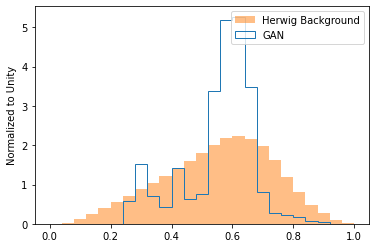

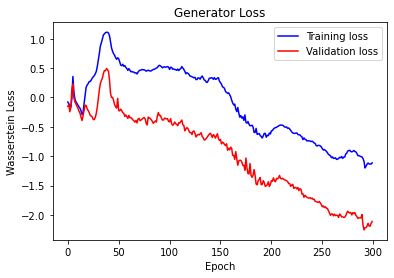

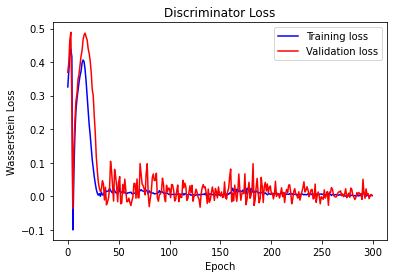

 31%|███████████████████████▎                                                   | 310/1000 [2:02:13<4:30:08, 23.49s/it]


Epoch 310:

Generator training loss: -1.4885316217531923
Discriminator training loss: 0.004503142474232681

Generator validation loss: -2.3816462598863195
Discriminator validation loss: 0.010280731691383436


 32%|████████████████████████                                                   | 320/1000 [2:06:10<4:27:19, 23.59s/it]


Epoch 320:

Generator training loss: -1.6730437454630116
Discriminator training loss: 0.004212887340874828

Generator validation loss: -2.52331729795112
Discriminator validation loss: 0.023174939862521986


 33%|████████████████████████▊                                                  | 330/1000 [2:10:04<4:21:18, 23.40s/it]


Epoch 330:

Generator training loss: -1.7009125908867258
Discriminator training loss: 0.0033856069726997174

Generator validation loss: -2.522903717932154
Discriminator validation loss: -0.023003976514417924


 34%|█████████████████████████▌                                                 | 340/1000 [2:14:00<4:18:52, 23.53s/it]


Epoch 340:

Generator training loss: -1.4888426490494462
Discriminator training loss: 0.002433004834982385

Generator validation loss: -2.4607522077247745
Discriminator validation loss: 0.03758639274043371


 35%|██████████████████████████▎                                                | 350/1000 [2:17:55<4:14:19, 23.48s/it]


Epoch 350:

Generator training loss: -1.33246849029442
Discriminator training loss: 0.0017200337203958737

Generator validation loss: -2.3570722966897684
Discriminator validation loss: 0.025120136421436224


 36%|███████████████████████████                                                | 360/1000 [2:21:50<4:11:02, 23.54s/it]


Epoch 360:

Generator training loss: -1.338312845901062
Discriminator training loss: 0.0010362903817321602

Generator validation loss: -2.3750999003160196
Discriminator validation loss: 0.008374620542229825


 37%|███████████████████████████▊                                               | 370/1000 [2:25:45<4:07:35, 23.58s/it]


Epoch 370:

Generator training loss: -1.3546556799463887
Discriminator training loss: 0.0009031385276609741

Generator validation loss: -2.401247721226489
Discriminator validation loss: -0.004897185083329353


 38%|████████████████████████████▌                                              | 380/1000 [2:29:41<4:04:08, 23.63s/it]


Epoch 380:

Generator training loss: -1.4496507836821302
Discriminator training loss: 0.0005819575169472875

Generator validation loss: -2.5194733113539023
Discriminator validation loss: 0.04253465058635081


 39%|█████████████████████████████▎                                             | 390/1000 [2:33:36<3:59:23, 23.55s/it]


Epoch 390:

Generator training loss: -1.4337632807551837
Discriminator training loss: 0.002238037773127136

Generator validation loss: -2.486800916859361
Discriminator validation loss: 0.001664690849017953


 40%|█████████████████████████████▉                                             | 399/1000 [2:37:08<3:54:28, 23.41s/it]


Epoch 400:

Generator training loss: -1.4664060569526067
Discriminator training loss: 0.0009687575423835808

Generator validation loss: -2.5391295132089833
Discriminator validation loss: 0.008345003232057398

Epoch 400:


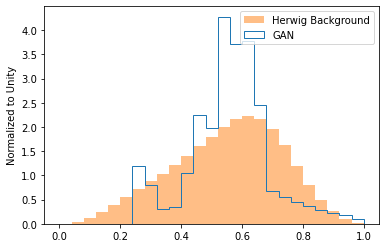

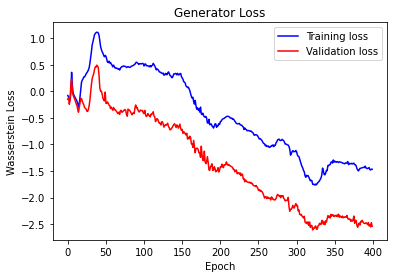

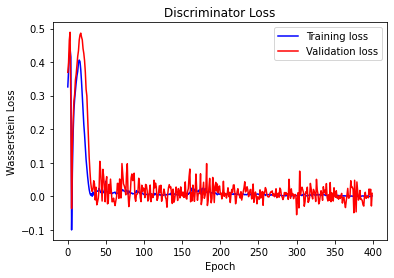

 41%|██████████████████████████████▋                                            | 410/1000 [2:41:28<3:52:55, 23.69s/it]


Epoch 410:

Generator training loss: -1.5316321110464837
Discriminator training loss: 0.0011563363709082113

Generator validation loss: -2.594602074779448
Discriminator validation loss: 0.003930149393916687


 42%|███████████████████████████████▌                                           | 420/1000 [2:45:24<3:48:33, 23.64s/it]


Epoch 420:

Generator training loss: -1.5599297726414894
Discriminator training loss: -0.00038261581733328216

Generator validation loss: -2.6098938818837776
Discriminator validation loss: 0.02687435090619609


 43%|████████████████████████████████▎                                          | 430/1000 [2:49:21<3:45:09, 23.70s/it]


Epoch 430:

Generator training loss: -1.6556485725230858
Discriminator training loss: 0.0002501511668430143

Generator validation loss: -2.6400549597427494
Discriminator validation loss: -0.024793248544349316


 44%|█████████████████████████████████                                          | 440/1000 [2:53:17<3:40:07, 23.58s/it]


Epoch 440:

Generator training loss: -1.624303619718291
Discriminator training loss: 0.0005727653921591507

Generator validation loss: -2.6252559697041744
Discriminator validation loss: -0.010628029908804789


 45%|█████████████████████████████████▊                                         | 450/1000 [2:57:12<3:36:45, 23.65s/it]


Epoch 450:

Generator training loss: -1.6046156226937236
Discriminator training loss: 0.0010059074319955063

Generator validation loss: -2.6675219682396434
Discriminator validation loss: 0.0061462565721084215


 46%|██████████████████████████████████▌                                        | 460/1000 [3:01:09<3:31:58, 23.55s/it]


Epoch 460:

Generator training loss: -1.7220204483941604
Discriminator training loss: 0.0003527317957576615

Generator validation loss: -2.719791634160964
Discriminator validation loss: -0.035520364759636845


 47%|███████████████████████████████████▎                                       | 470/1000 [3:05:05<3:28:34, 23.61s/it]


Epoch 470:

Generator training loss: -1.6712952588425307
Discriminator training loss: 0.0014236654563329401

Generator validation loss: -2.7157189777640047
Discriminator validation loss: 0.025325572455958387


 48%|████████████████████████████████████                                       | 480/1000 [3:09:01<3:24:48, 23.63s/it]


Epoch 480:

Generator training loss: -1.7529912309242728
Discriminator training loss: 0.0006946907526155789

Generator validation loss: -2.740105574248267
Discriminator validation loss: 0.010852458748946655


 49%|████████████████████████████████████▊                                      | 490/1000 [3:12:58<3:20:50, 23.63s/it]


Epoch 490:

Generator training loss: -1.9349330341229674
Discriminator training loss: 0.00020662267947880566

Generator validation loss: -2.854975576283502
Discriminator validation loss: 0.007880289055734823


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:16:29<3:15:59, 23.47s/it]


Epoch 500:

Generator training loss: -2.0842993721935916
Discriminator training loss: 0.0022051133432692263

Generator validation loss: -3.003576698850413
Discriminator validation loss: 0.02671814672245747

Epoch 500:


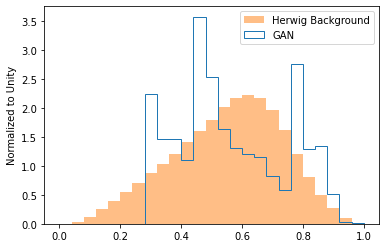

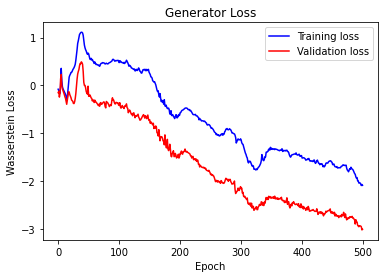

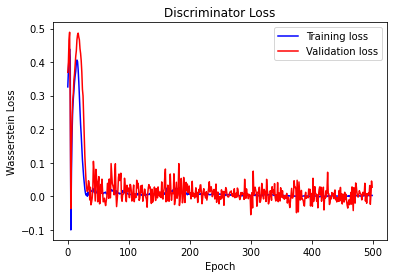

 51%|██████████████████████████████████████▎                                    | 510/1000 [3:20:50<3:13:24, 23.68s/it]


Epoch 510:

Generator training loss: -1.9783526160677924
Discriminator training loss: 0.0038142892745160624

Generator validation loss: -2.918445303791859
Discriminator validation loss: -0.0006764382463889426


 52%|███████████████████████████████████████                                    | 520/1000 [3:24:45<3:07:57, 23.49s/it]


Epoch 520:

Generator training loss: -2.073287384920433
Discriminator training loss: 0.0008630227074325654

Generator validation loss: -2.9666379103895095
Discriminator validation loss: 0.01506429066696418


 53%|███████████████████████████████████████▊                                   | 530/1000 [3:28:41<3:04:22, 23.54s/it]


Epoch 530:

Generator training loss: -2.144033487540125
Discriminator training loss: 0.003474880114700418

Generator validation loss: -3.0459075687361543
Discriminator validation loss: 0.020102483809810633


 54%|████████████████████████████████████████▌                                  | 540/1000 [3:32:36<3:00:50, 23.59s/it]


Epoch 540:

Generator training loss: -2.245097923799942
Discriminator training loss: 0.004446326824650309

Generator validation loss: -3.0922316029423573
Discriminator validation loss: 0.0029146892501488927


 55%|█████████████████████████████████████████▎                                 | 550/1000 [3:36:32<2:56:47, 23.57s/it]


Epoch 550:

Generator training loss: -2.2679927599886076
Discriminator training loss: 0.0028306866242073835

Generator validation loss: -3.0953622518992816
Discriminator validation loss: -0.00574151675129065


 56%|██████████████████████████████████████████                                 | 560/1000 [3:40:27<2:52:12, 23.48s/it]


Epoch 560:

Generator training loss: -2.2408772013226494
Discriminator training loss: 0.0023958249915238938

Generator validation loss: -3.156125786851664
Discriminator validation loss: 0.021730931467409093


 57%|██████████████████████████████████████████▋                                | 570/1000 [3:44:22<2:48:26, 23.50s/it]


Epoch 570:

Generator training loss: -2.2649885963221066
Discriminator training loss: 0.0031890081404540712

Generator validation loss: -3.106277283097877
Discriminator validation loss: -0.025950937452807174


 58%|███████████████████████████████████████████▌                               | 580/1000 [3:48:17<2:44:37, 23.52s/it]


Epoch 580:

Generator training loss: -2.2050222796820553
Discriminator training loss: 0.0036234760693074205

Generator validation loss: -3.1242531205787034
Discriminator validation loss: -0.023209116914019477


 59%|████████████████████████████████████████████▎                              | 590/1000 [3:52:12<2:40:30, 23.49s/it]


Epoch 590:

Generator training loss: -2.2117835700186226
Discriminator training loss: 0.0012543974305798324

Generator validation loss: -3.1682985122086573
Discriminator validation loss: 0.009510082017320693


 60%|████████████████████████████████████████████▉                              | 599/1000 [3:55:43<2:36:23, 23.40s/it]


Epoch 600:

Generator training loss: -2.0066958550221283
Discriminator training loss: 0.00010536173054798317

Generator validation loss: -2.990734416930402
Discriminator validation loss: 0.01620854755060091

Epoch 600:


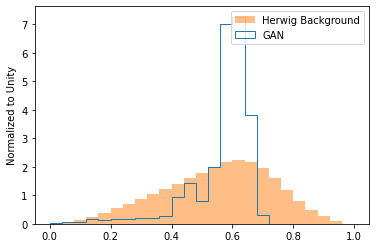

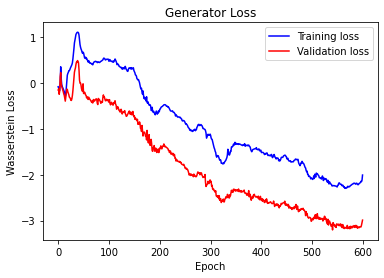

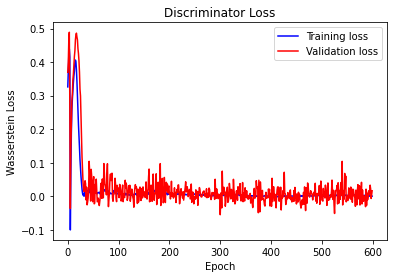

 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:00:03<2:33:29, 23.61s/it]


Epoch 610:

Generator training loss: -2.101945490784984
Discriminator training loss: 0.0017697448080150418

Generator validation loss: -3.0823501289867963
Discriminator validation loss: 0.020291434665294174


In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z